### Table of Contents
* [Introduction](#introduction)
* [Data Type Conversion](#data-type-conversion)
* [Data Cleaning](#data-cleaning)
* [Data Cleaning Summary](#data-cleaning-summary)
* [Feature Engineering](#feature-engineering)
* [Feature Engineering Summary](#feature-engineering-summary)




## Introduction

This notebook focuses on **data cleaning** and **feature engineering** for the HIV patient dataset. The dataset, referred to as the **Ampath Patient dataset**, contains **1.89 million** visit records collected over multiple years from the clinic. Each record captures essential information about a patient's visit, health status, and treatment history.

#### Purpose:
The purpose of this notebook is twofold:
1. **Data Cleaning**:
   - Address missing values and inconsistencies in the dataset.
   - Prepare the data for analysis and modeling by ensuring completeness, consistency, and correctness.
2. **Feature Engineering**:
   - Create meaningful features that enhance predictive modeling capabilities for use cases such as patient adherence, treatment interruption, etc.


In [2]:
! pip install -q pandas numpy matplotlib seaborn openpyxl matplotlib_venn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
ampath_patient_data = pd.read_csv("data/Ampath_patient_data.csv")

### All available columns/features

In [5]:
ampath_patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891863 entries, 0 to 1891862
Data columns (total 21 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   patient_identifier              object
 1   person_id                       int64 
 2   gender                          object
 3   birthdate                       object
 4   Encounter_Date                  object
 5   height                          object
 6   weight                          object
 7   Next_clinical_appointment       object
 8   Diagnosis_Date                  object
 9   Tuberculosis_Treatment_Plan     int64 
 10  Current_WHO_HIV_Stage           object
 11  CD4_Count                       object
 12  Is_ART                          object
 13  Is_PMTCT                        object
 14  Viral_Load                      object
 15  Adherence                       object
 16  Education_Level                 object
 17  Screening_For_STI               int64 
 18  Cl

### Checking for count of missing values

In [6]:
# check for missing values \N is also considered as missing value
ampath_patient_data.replace(r'\N', pd.NA, inplace=True)
ampath_patient_data.isnull().sum()

patient_identifier                      0
person_id                               0
gender                                  0
birthdate                               0
Encounter_Date                          0
height                              88406
weight                              15370
Next_clinical_appointment          113268
Diagnosis_Date                          0
Tuberculosis_Treatment_Plan             0
Current_WHO_HIV_Stage              173594
CD4_Count                         1689694
Is_ART                             488674
Is_PMTCT                          1814338
Viral_Load                        1602893
Adherence                          959489
Education_Level                   1813203
Screening_For_STI                       0
Classification_Of_Malnutrition    1891863
Isoniazid_Use                      114640
Cotrimoxazole_Use                  432550
dtype: int64

### Handling Duplicate Records
#### Analysis
The dataset initially contained ~2 million individual encounters, with multiple records for the same patient on the same day. These duplicate records were confirmed by the AMPATH team to occur when a variable is updated during a visit. Keeping all these records would lead to data redundancy and inaccuracies in analysis.

#### Approach
1. **Sort by `person_id` and `Encounter_Date`**:
   - Ensures chronological order within each patient group.
2. **Drop Duplicates**:
   - Retain only the latest record for each combination of `person_id` and `Encounter_Date`.
3. **Reset Index**:
   - Reindex the cleaned dataset for consistency.


#### Outcome
The cleaned dataset now contains **1.7 million records**, with duplicate rows removed. Each record represents the most recent update for a given patient on a specific encounter date, ensuring data accuracy and reducing redundancy.



In [7]:
# Sort by person_id and Encounter_Date (ensure Encounter_Date is datetime)
ampath_patient_data['Encounter_Date'] = pd.to_datetime(ampath_patient_data['Encounter_Date'], errors='coerce')

# Sort by person_id and Encounter_Date to ensure chronological order
ampath_patient_data = ampath_patient_data.sort_values(by=['person_id', 'Encounter_Date'], ascending=[True, True])

# Drop duplicates based on person_id and Encounter_Date, keeping the last row
ampath_patient_data_cleaned = ampath_patient_data.drop_duplicates(subset=['person_id', 'Encounter_Date'], keep='last')

ampath_patient_data_cleaned.reset_index(drop=True, inplace=True)

# Display a sample of the cleaned dataset to verify
print(ampath_patient_data_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706797 entries, 0 to 1706796
Data columns (total 21 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   patient_identifier              object        
 1   person_id                       int64         
 2   gender                          object        
 3   birthdate                       object        
 4   Encounter_Date                  datetime64[ns]
 5   height                          object        
 6   weight                          object        
 7   Next_clinical_appointment       object        
 8   Diagnosis_Date                  object        
 9   Tuberculosis_Treatment_Plan     int64         
 10  Current_WHO_HIV_Stage           object        
 11  CD4_Count                       object        
 12  Is_ART                          object        
 13  Is_PMTCT                        object        
 14  Viral_Load                      object        
 15

In [8]:
# Save the cleaned dataset to a new CSV file
ampath_patient_data_cleaned.to_csv('data/Ampath_patient_data_cleaned.csv', index=False)

#### Identify Columns with High Missing Values
 In this step, we aim to identify columns with more than 50% missing values. These columns will be evaluated to decide whether they should be removed or retained based on their relevance to predicting treatment interruption.



Columns with >50% missing values:
CD4_Count                          93.354101
Is_PMTCT                           96.066726
Viral_Load                         84.636837
Education_Level                    96.402150
Classification_Of_Malnutrition    100.000000
dtype: float64


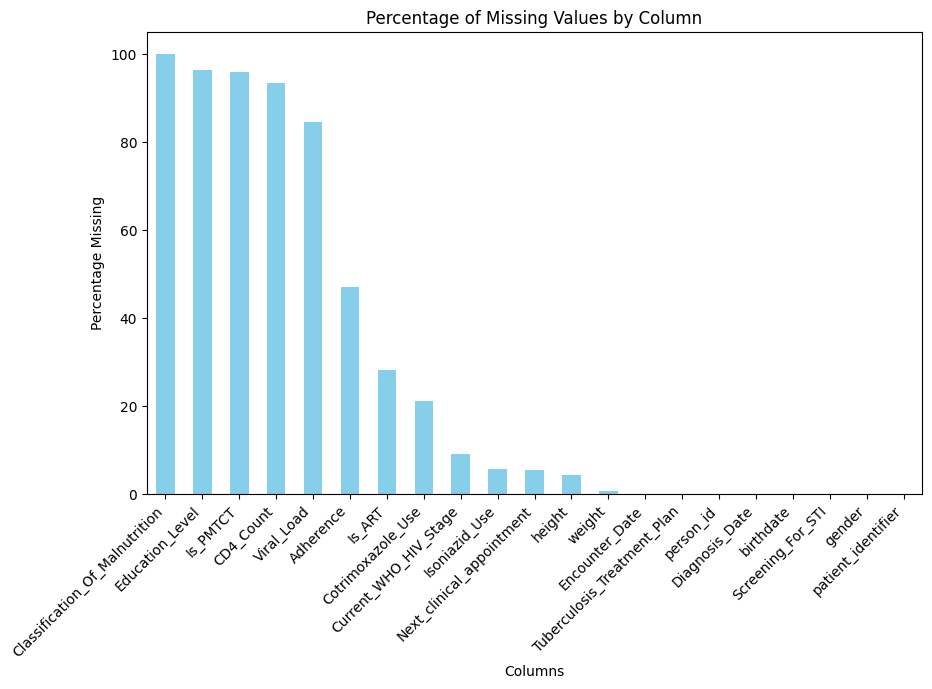

In [9]:
# Calculate the percentage of missing values for each column
missing_percentage = (ampath_patient_data_cleaned.isnull().sum() / len(ampath_patient_data_cleaned)) * 100

# Identify columns with a high percentage of missing values (e.g., >50%)
high_missing_columns = missing_percentage[missing_percentage > 50]

# Display the columns with their missing percentages
print("Columns with >50% missing values:")
print(high_missing_columns)



plt.figure(figsize=(10, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.show()


### Remove Columns with High Missing Values
In this step, we identify columns with more than 50% missing values and decide whether to keep or remove them based on their relevance to predicting treatment interruption (LTFU).

### Columns to Remove:

`Classification_Of_Malnutrition`: Fully missing (100%).

`Education_Level`: High missingness (96.40%) and limited relevance.

`Is_PMTCT`: High missingness (96.06%) and specific to a subset of patients.

### Columns to Keep:

`CD4_Count`: Critical predictor of disease progression.

`Viral_Load`: Essential for monitoring treatment adherence.

In [10]:
# Remove columns that are deemed irrelevant or fully missing
columns_to_drop = ['Classification_Of_Malnutrition', 'Education_Level', 'Is_PMTCT']
ampath_patient_data_cleaned.drop(columns=columns_to_drop, inplace=True)

# Verify remaining columns
print("Remaining Columns After Dropping:")
print(ampath_patient_data_cleaned.info())

Remaining Columns After Dropping:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706797 entries, 0 to 1706796
Data columns (total 18 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   patient_identifier           object        
 1   person_id                    int64         
 2   gender                       object        
 3   birthdate                    object        
 4   Encounter_Date               datetime64[ns]
 5   height                       object        
 6   weight                       object        
 7   Next_clinical_appointment    object        
 8   Diagnosis_Date               object        
 9   Tuberculosis_Treatment_Plan  int64         
 10  Current_WHO_HIV_Stage        object        
 11  CD4_Count                    object        
 12  Is_ART                       object        
 13  Viral_Load                   object        
 14  Adherence                    object        
 15  Screening_For_S

### Data Type Conversion
We are converting the columns in the dataset to their appropriate data types to ensure compatibility and efficiency for analysis and modeling. This process prepares the data for operations like mathematical calculations, date manipulations, and categorical analysis.



In [11]:

# 1. Convert `patient_identifier` to string
ampath_patient_data_cleaned['patient_identifier'] = ampath_patient_data_cleaned['patient_identifier'].astype('string')

# 2. `person_id` is already int64, no changes needed

# 3. Convert `gender` to categorical
ampath_patient_data_cleaned['gender'] = ampath_patient_data_cleaned['gender'].astype('category')

# 4. Convert `birthdate` to datetime
ampath_patient_data_cleaned['birthdate'] = pd.to_datetime(ampath_patient_data_cleaned['birthdate'], errors='coerce')

# 5. `Encounter_Date` is already datetime, no changes needed

# 6. Convert `height` and `weight` to numeric
ampath_patient_data_cleaned['height'] = pd.to_numeric(ampath_patient_data_cleaned['height'], errors='coerce')
ampath_patient_data_cleaned['weight'] = pd.to_numeric(ampath_patient_data_cleaned['weight'], errors='coerce')

# 7. Convert `Next_clinical_appointment`, `Diagnosis_Date` and 'Cotrimoxazole_Use' to datetime
ampath_patient_data_cleaned['Next_clinical_appointment'] = pd.to_datetime(
    ampath_patient_data_cleaned['Next_clinical_appointment'], errors='coerce'
)
ampath_patient_data_cleaned['Diagnosis_Date'] = pd.to_datetime(
    ampath_patient_data_cleaned['Diagnosis_Date'], errors='coerce'
)
ampath_patient_data_cleaned['Cotrimoxazole_Use'] = pd.to_datetime(
    ampath_patient_data_cleaned['Cotrimoxazole_Use'], errors='coerce'
)

# 8. `Tuberculosis_Treatment_Plan` is already int64, no changes needed

# 9. Convert `Current_WHO_HIV_Stage` to categorical
ampath_patient_data_cleaned['Current_WHO_HIV_Stage'] = ampath_patient_data_cleaned['Current_WHO_HIV_Stage'].astype('category')

# 10. Convert `CD4_Count` and `Viral_Load` to numeric
ampath_patient_data_cleaned['CD4_Count'] = pd.to_numeric(ampath_patient_data_cleaned['CD4_Count'], errors='coerce')
ampath_patient_data_cleaned['Viral_Load'] = pd.to_numeric(ampath_patient_data_cleaned['Viral_Load'], errors='coerce')

# 11. Convert `Is_ART` and `Isoniazid_Use` to numeric
binary_columns = ['Is_ART', 'Isoniazid_Use']
for col in binary_columns:
    ampath_patient_data_cleaned[col] = pd.to_numeric(ampath_patient_data_cleaned[col], errors='coerce')

# 12. Convert `Adherence` to categorical
ampath_patient_data_cleaned['Adherence'] = ampath_patient_data_cleaned['Adherence'].astype('category')

# 13. `Screening_For_STI` is already int64, no changes needed

# Display updated data types for verification
print("\nUpdated Data Types:")
print(ampath_patient_data_cleaned.dtypes)



Updated Data Types:
patient_identifier             string[python]
person_id                               int64
gender                               category
birthdate                      datetime64[ns]
Encounter_Date                 datetime64[ns]
height                                float64
weight                                float64
Next_clinical_appointment      datetime64[ns]
Diagnosis_Date                 datetime64[ns]
Tuberculosis_Treatment_Plan             int64
Current_WHO_HIV_Stage                category
CD4_Count                             float64
Is_ART                                float64
Viral_Load                            float64
Adherence                            category
Screening_For_STI                       int64
Isoniazid_Use                         float64
Cotrimoxazole_Use              datetime64[ns]
dtype: object


## Data Cleaning

### Remove Rows with Missing Encounter_Date
#### Analysis
The `Encounter_Date` column is critical for tracking patient visits and calculating temporal features. There are very few rows where `Encounter_Date` is missing, and imputing these values could introduce inaccuracies.

#### Approach
1. **Identify Missing Rows**:
   - Extract rows where `Encounter_Date` is null.
2. **Remove Missing Rows**:
   - Drop rows with missing `Encounter_Date` to ensure data integrity.


In [12]:
# Identify rows with missing Encounter_Date
rows_with_missing_dates = ampath_patient_data_cleaned[ampath_patient_data_cleaned['Encounter_Date'].isna()]

# Remove rows with missing Encounter_Date
ampath_patient_data_cleaned = ampath_patient_data_cleaned[ampath_patient_data_cleaned['Encounter_Date'].notna()]



### Height (75,585 Missing Values)
#### Analysis
Height has 75,585 missing values. In adults, height is relatively stable across time, with minor variations typically due to measurement error or age-related changes. Missing values may occur due to clinicians skipping measurements when focused on more immediate health concerns.

#### Approach
1. **Within-patient temporal filling**:
   - For patients with at least one height measurement, use forward-fill followed by backward-fill to utilize temporally adjacent measurements.
   - This respects the biological reality that height remains relatively stable for adults.

2. **Demographic-based imputation for remaining patients**:
   - For patients with no height recorded, impute using median values stratified by gender and age groups.
   - This approach is supported by clinical literature on anthropometric imputation.

In [13]:
# Forward and backward fill height within each patient
ampath_patient_data_cleaned['height'] = ampath_patient_data_cleaned.groupby('person_id')['height'].transform(lambda x: x.ffill().bfill())

# Calculate age at encounter (handle invalid dates)
ampath_patient_data_cleaned['age_at_encounter'] = (
    (ampath_patient_data_cleaned['Encounter_Date'] - pd.to_datetime(ampath_patient_data_cleaned['birthdate'], errors='coerce'))
    .dt.days / 365.25
)

# Create age groups with corrected bins and handle missing values
bins = [0, 18, 30, 45, 60, 120]  # Added <18 category
labels = ['<18', '18-30', '31-45', '46-60', '61+']
ampath_patient_data_cleaned['age_group'] = (
    pd.cut(ampath_patient_data_cleaned['age_at_encounter'],
           bins=bins,
           labels=labels,
           right=False)  # Include left bin edge
    .cat.add_categories('unknown')
    .fillna('unknown')  # Handle NaN from invalid/missing dates
)

# Calculate median height by gender and age group (including 'unknown')
median_heights = ampath_patient_data_cleaned.groupby(['gender', 'age_group'])['height'].transform('median')

# Final imputation
ampath_patient_data_cleaned['height'] = ampath_patient_data_cleaned['height'].fillna(median_heights)

# Verify results
print("Missing values in age_group:", ampath_patient_data_cleaned['age_group'].isna().sum())
print("Missing values in height:", ampath_patient_data_cleaned['height'].isna().sum())


Missing values in age_group: 0
Missing values in height: 0


### Weight (14,171 Missing Values)

#### Analysis
Weight has 14,171 missing values. Unlike height, weight can fluctuate significantly over time due to disease progression, medication effects, and other health factors. In HIV treatment, weight changes can be clinically significant indicators of treatment efficacy.

#### Approach
1. **Linear interpolation within patients**:
   - For patients with at least two weight measurements, use linear interpolation to estimate weights between known measurements.
   - This accounts for the temporal trends in weight changes rather than assuming stability.

2. **Forward/backward fill remaining gaps**:
   - For dates beyond the range of available measurements, use forward and backward fill.

3. **Demographic-based imputation for remaining patients**:
   - For patients with no weight recorded, impute using stratified medians based on gender, age group, and HIV stage.

In [14]:
# Sort data for proper interpolation
ampath_patient_data_cleaned = ampath_patient_data_cleaned.sort_values(['person_id', 'Encounter_Date'])

# Linear interpolation within each patient
ampath_patient_data_cleaned['weight'] = ampath_patient_data_cleaned.groupby('person_id')['weight'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both'))

# Forward/backward fill remaining gaps
ampath_patient_data_cleaned['weight'] = ampath_patient_data_cleaned.groupby('person_id')['weight'].transform(
    lambda x: x.ffill().bfill())

# Stratified imputation for patients with no weight data
median_weights = ampath_patient_data_cleaned.groupby(['gender', 'age_group'])['weight'].transform('median')
ampath_patient_data_cleaned['weight'] = ampath_patient_data_cleaned['weight'].fillna(median_weights)


### Next_clinical_appointment (95,749 Missing Values)

#### Analysis
This column has 95,749 missing values. Missingness here is potentially informative - it could indicate that no follow-up was scheduled, which might predict treatment interruption. Research indicates that missing appointment data is highly predictive of patient retention in HIV care.

#### Approach
1. **Binary appointment indicator**:
   - Create a new feature (`appointment_scheduled`) indicating whether a next appointment was scheduled.
   - This preserves the informative nature of missingness.

2. **Time-based imputation**:
   - For cases where we need date values, impute based on patient-specific appointment patterns or clinic protocols.
   - Use median time between appointments for each patient when available.

3. **Flag imputed values**:
   - Create indicators to identify which values were imputed for transparency.


In [15]:
# Create binary indicator for scheduled appointments
ampath_patient_data_cleaned['appointment_scheduled'] = (
    ampath_patient_data_cleaned['Next_clinical_appointment'].notna().astype(int)
)

# Calculate days between consecutive encounters
ampath_patient_data_cleaned['days_to_next_actual_visit'] = (
    ampath_patient_data_cleaned.groupby('person_id')['Encounter_Date'].shift(-1) - 
    ampath_patient_data_cleaned['Encounter_Date']
).dt.days

# Impute missing days_to_next_actual_visit
# --------------------------------------------------------
# Calculate patient-specific median follow-up days
median_followup = ampath_patient_data_cleaned.groupby('person_id')['days_to_next_actual_visit'].median()

# Use clinic-wide median as fallback
global_median_followup = median_followup.median()
patient_median_followup = ampath_patient_data_cleaned['person_id'].map(median_followup).fillna(global_median_followup)

# Fill missing values hierarchically
ampath_patient_data_cleaned['days_to_next_actual_visit'] = (
    ampath_patient_data_cleaned['days_to_next_actual_visit']
    .fillna(patient_median_followup)
    .astype(int)
)

# Impute missing Next_clinical_appointment dates
# --------------------------------------------------------
mask = ampath_patient_data_cleaned['Next_clinical_appointment'].isna()
ampath_patient_data_cleaned.loc[mask, 'Next_clinical_appointment'] = (
    ampath_patient_data_cleaned.loc[mask, 'Encounter_Date'] + 
    pd.to_timedelta(patient_median_followup[mask].values, unit='D')
)

# Create imputation flag
ampath_patient_data_cleaned['next_appointment_imputed'] = mask.astype(int)

# Verify results
print("Missing values in days_to_next_actual_visit:", 
      ampath_patient_data_cleaned['days_to_next_actual_visit'].isna().sum())
print("Missing values in Next_clinical_appointment:", 
      ampath_patient_data_cleaned['Next_clinical_appointment'].isna().sum())


Missing values in days_to_next_actual_visit: 0
Missing values in Next_clinical_appointment: 0


### Diagnosis_Date (Missing Values)

#### Analysis
The `Diagnosis_Date` column contains missing values for some patients. This information is critical for calculating disease duration and understanding treatment timelines. Missing diagnosis dates would prevent accurate calculation of features like "time since diagnosis at scheduled appointment."

#### Approach
1. **Identify Patients with Missing Diagnosis Dates**:
   - Extract all unique patient IDs (`person_id`) where `Diagnosis_Date` is null.
2. **Use Earliest Encounter as Proxy**:
   - For each patient with missing diagnosis date, use their earliest recorded `Encounter_Date` as a reasonable approximation.
   - This assumes that the first clinical encounter likely occurred near the time of diagnosis.


In [16]:
# Identify patients with missing Diagnosis_Date
patients_missing_diagnosis = ampath_patient_data_cleaned[
    ampath_patient_data_cleaned['Diagnosis_Date'].isna()
]['person_id'].unique()

# For patients with missing Diagnosis_Date, use their earliest Encounter_Date as proxy
for patient in patients_missing_diagnosis:
    earliest_encounter = ampath_patient_data_cleaned[
        ampath_patient_data_cleaned['person_id'] == patient
    ]['Encounter_Date'].min()
    
    ampath_patient_data_cleaned.loc[
        ampath_patient_data_cleaned['person_id'] == patient, 'Diagnosis_Date'
    ] = earliest_encounter



#### CD4_Count and Viral_Load (1,593,365 and 1,444,579 Missing Values)

##### Analysis
These clinical markers have substantial missing values (93.4% for `CD4_Count` and 84.6% for `Viral_Load`). They are critical predictors of disease progression and treatment adherence. Missingness is addressed using a hierarchical imputation strategy that respects temporal trends while ensuring complete data.

##### Approach
1. **Forward-fill within patient groups**:
   - Propagate recent values within each patient's timeline.
2. **Time decay adjustment**:
   - Apply a decay factor to forward-filled values based on time elapsed since last measurement, accounting for decreasing reliability of older data.
3. **Median imputation for remaining missing values**:
   - For patients with no recorded values, use population-level median as a fallback.



In [17]:
# Ensure CD4_Count and Viral_Load are numeric
ampath_patient_data_cleaned['CD4_Count'] = pd.to_numeric(ampath_patient_data_cleaned['CD4_Count'], errors='coerce')
ampath_patient_data_cleaned['Viral_Load'] = pd.to_numeric(ampath_patient_data_cleaned['Viral_Load'], errors='coerce')

# Handle CD4_Count and Viral_Load with time decay and fallback imputation
for col in ['CD4_Count', 'Viral_Load']:
    # Sort by person_id and Encounter_Date for proper chronological order
    ampath_patient_data_cleaned = ampath_patient_data_cleaned.sort_values(['person_id', 'Encounter_Date'])
    
    # Forward-fill within patient groups
    ampath_patient_data_cleaned[f'{col}_ffilled'] = ampath_patient_data_cleaned.groupby('person_id')[col].ffill()
    
    # Calculate days since last measurement
    ampath_patient_data_cleaned[f'days_since_last_{col}'] = ampath_patient_data_cleaned.groupby('person_id').apply(
        lambda x: (x['Encounter_Date'] - x['Encounter_Date'].shift(1)).dt.days
    ).reset_index(level=0, drop=True)
    
    # Apply time decay factor (e.g., reliability decreases by 10% every 90 days)
    decay_factor = 0.9 ** (ampath_patient_data_cleaned[f'days_since_last_{col}'] / 90)
    mask = ampath_patient_data_cleaned[col].isna() & ampath_patient_data_cleaned[f'{col}_ffilled'].notna()
    
    # Apply decayed values where original is missing but forward-filled value exists
    ampath_patient_data_cleaned.loc[mask, col] = ampath_patient_data_cleaned.loc[mask, f'{col}_ffilled'] * decay_factor
    
    # Drop temporary columns
    ampath_patient_data_cleaned = ampath_patient_data_cleaned.drop([f'{col}_ffilled', f'days_since_last_{col}'], axis=1)
    
    # Median imputation for remaining missing values
    median_value = ampath_patient_data_cleaned[col].median()
    ampath_patient_data_cleaned[col] = ampath_patient_data_cleaned[col].fillna(median_value)

# Verify results
print("Missing values after handling:")
print(ampath_patient_data_cleaned[['CD4_Count', 'Viral_Load']].isna().sum())


Missing values after handling:
CD4_Count     0
Viral_Load    0
dtype: int64


### Current_WHO_HIV_Stage (155,009 Missing Values)

#### Analysis
Current_WHO_HIV_Stage has 155,009 missing values. This feature represents the clinical staging of HIV disease severity according to WHO classification (Stage 1-4).

#### Approach
1. **Forward-fill within patient groups**:
   - Forward-fill WHO HIV stage values within each patient group, as this clinical assessment typically changes infrequently.
   - This preserves the temporal progression of disease staging.

2. **Create 'unknown' category for remaining missing values**:
   - For patients with no WHO stage recorded, create and assign an 'unknown' category.
   - This approach preserves information about missingness, which may itself be clinically meaningful.
   - Clinical appropriateness: WHO staging is a clinical assessment that shouldn't be estimated through statistical methods.
   - Avoids bias from backward filling, as a patient's condition can improve or deteriorate over time.
   - Maintains clear interpretability for healthcare providers.



In [18]:
# Forward-fill WHO HIV stage (changes infrequently)
ampath_patient_data_cleaned['Current_WHO_HIV_Stage'] = ampath_patient_data_cleaned.groupby('person_id')['Current_WHO_HIV_Stage'].ffill()

# For patients with no WHO stage, create 'unknown' category
if ampath_patient_data_cleaned['Current_WHO_HIV_Stage'].isna().any():
    # Get current categories
    current_categories = ampath_patient_data_cleaned['Current_WHO_HIV_Stage'].cat.categories.tolist()
    # Add 'unknown' category
    new_categories = current_categories + ['unknown']
    # Update categorical type with new categories
    ampath_patient_data_cleaned['Current_WHO_HIV_Stage'] = ampath_patient_data_cleaned['Current_WHO_HIV_Stage'].cat.set_categories(new_categories)
    # Fill NAs with 'unknown'
    ampath_patient_data_cleaned['Current_WHO_HIV_Stage'] = ampath_patient_data_cleaned['Current_WHO_HIV_Stage'].fillna('unknown')


### Treatment Columns (Is_ART, Isoniazid_Use)

#### Analysis
The treatment columns `Is_ART` and `Isoniazid_Use` contain missing values. These columns indicate whether a patient is on antiretroviral therapy (ART) and isoniazid preventive therapy, respectively. Treatment status typically remains consistent over time unless explicitly changed.

#### Approach
1. **Forward-fill within patient groups**:
   - Propagate known treatment status forward within each patient's timeline.
   - This assumes that once treatment starts, it continues until explicitly stopped.

2. **Backward-fill within patient groups**:
   - Fill gaps at the beginning of the timeline by propagating values backward.
   - This ensures complete treatment history for each patient.

3. **Fill remaining missing values**:
   - For patients with no recorded treatment status, fill with 0 (indicating no medication).
   - This provides a conservative assumption for patients with no treatment data.


In [19]:
# Define treatment columns
treatment_cols = ['Is_ART', 'Isoniazid_Use']

# Handle Is_ART and Isoniazid_Use
for col in treatment_cols:
    # Forward-fill treatment status within each patient group
    ampath_patient_data_cleaned[col] = ampath_patient_data_cleaned.groupby('person_id')[col].ffill()

    # Backward-fill treatment status within each patient group
    ampath_patient_data_cleaned[col] = ampath_patient_data_cleaned.groupby('person_id')[col].bfill()

    # Fill remaining missing values with 0 (indicating no medication)
    ampath_patient_data_cleaned[col] = ampath_patient_data_cleaned[col].fillna(0)





#### Cotrimoxazole_Use and Cotrimoxazole_duration

##### Analysis
The `Cotrimoxazole_Use` column records the start date of Cotrimoxazole usage, while `Cotrimoxazole_duration` represents the number of days a patient has been on the medication. 

##### Approach
1. **Forward-fill within patient groups**:
   - Propagate known usage dates forward within each patient's timeline.
2. **Fill missing values with earliest encounter date**:
   - For patients with no recorded usage, fill missing values in `Cotrimoxazole_Use` with their earliest `Encounter_Date`.
3. **Calculate duration**:
   - Compute the difference between `Encounter_Date` and the first recorded usage date.
4. **Ensure completeness**:
   - Fill any remaining missing durations with 0 to indicate no usage history.



In [20]:
# Ensure Cotrimoxazole_Use is in datetime format
ampath_patient_data_cleaned['Cotrimoxazole_Use'] = pd.to_datetime(
    ampath_patient_data_cleaned['Cotrimoxazole_Use'], errors='coerce'
)

# Forward-fill Cotrimoxazole_Use within each patient group
ampath_patient_data_cleaned['Cotrimoxazole_Use'] = ampath_patient_data_cleaned.groupby('person_id')['Cotrimoxazole_Use'].ffill()

# Fill remaining missing Cotrimoxazole_Use with earliest Encounter_Date for each patient
earliest_encounter = ampath_patient_data_cleaned.groupby('person_id')['Encounter_Date'].transform('min')
ampath_patient_data_cleaned['Cotrimoxazole_Use'] = ampath_patient_data_cleaned['Cotrimoxazole_Use'].fillna(earliest_encounter)

# Calculate first Cotrimoxazole use date for each patient
first_cotrimoxazole_use = ampath_patient_data_cleaned.groupby('person_id')['Cotrimoxazole_Use'].transform('first')

# Calculate duration as the difference between Encounter_Date and first Cotrimoxazole_Use date
ampath_patient_data_cleaned['Cotrimoxazole_duration'] = (
    ampath_patient_data_cleaned['Encounter_Date'] - first_cotrimoxazole_use
).dt.days

# Fill any remaining missing values in duration with 0 (e.g., for patients with no valid dates)
ampath_patient_data_cleaned['Cotrimoxazole_duration'] = ampath_patient_data_cleaned['Cotrimoxazole_duration'].fillna(0).astype(int)

# Verify results
print("Missing values in Cotrimoxazole columns after handling:")
print(ampath_patient_data_cleaned[['Cotrimoxazole_Use', 'Cotrimoxazole_duration']].isna().sum())


Missing values in Cotrimoxazole columns after handling:
Cotrimoxazole_Use         0
Cotrimoxazole_duration    0
dtype: int64



#### Adherence (Categorical Missing Values)

##### Analysis
The `Adherence` column represents patient-reported medication compliance, which is a key predictor of treatment interruption and retention. Missing values are addressed using simple imputation techniques that preserve categorical distributions.

##### Approach
1. **Forward-fill and backward-fill within patient groups**:
   - Propagate known adherence levels within each patient's timeline to fill gaps.
2. **Mode imputation for remaining missing values**:
   - Fill missing values using the most frequent adherence category (`mode`) as a fallback.



In [21]:
ampath_patient_data_cleaned['Adherence'] = ampath_patient_data_cleaned.groupby('person_id')['Adherence'].ffill()
ampath_patient_data_cleaned['Adherence'] = ampath_patient_data_cleaned.groupby('person_id')['Adherence'].bfill()

# Fill remaining missing values in Adherence with mode
mode_value = ampath_patient_data_cleaned['Adherence'].mode()[0]
ampath_patient_data_cleaned['Adherence'] = ampath_patient_data_cleaned['Adherence'].fillna(mode_value)

# Verify results
print("Missing values after handling:")
print(ampath_patient_data_cleaned[[ 'Adherence']].isna().sum())

Missing values after handling:
Adherence    0
dtype: int64


## Data Cleaning Summary  
The original dataset contained **significant missing values** across critical clinical and demographic columns. After systematic cleaning:  
- **All missing values** have been resolved (all columns now show `0` missing values).  
- **Irrelevant columns** with near-complete missingness (e.g., `Classification_Of_Malnutrition`) were removed.  
- **New features** like `appointment_scheduled` and `Cotrimoxazole_duration` were added during the process.  

The dataset is now **complete and consistent**, with all null values addressed. This sets the stage for focused **feature engineering**.



### Null values present in the orginal dataset

In [22]:
ampath_patient_data.isnull().sum()

patient_identifier                      0
person_id                               0
gender                                  0
birthdate                               0
Encounter_Date                          2
height                              88406
weight                              15370
Next_clinical_appointment          113268
Diagnosis_Date                          0
Tuberculosis_Treatment_Plan             0
Current_WHO_HIV_Stage              173594
CD4_Count                         1689694
Is_ART                             488674
Is_PMTCT                          1814338
Viral_Load                        1602893
Adherence                          959489
Education_Level                   1813203
Screening_For_STI                       0
Classification_Of_Malnutrition    1891863
Isoniazid_Use                      114640
Cotrimoxazole_Use                  432550
dtype: int64

### Null values present in the cleaned dataset

In [23]:
ampath_patient_data_cleaned.isnull().sum()

patient_identifier             0
person_id                      0
gender                         0
birthdate                      0
Encounter_Date                 0
height                         0
weight                         0
Next_clinical_appointment      0
Diagnosis_Date                 0
Tuberculosis_Treatment_Plan    0
Current_WHO_HIV_Stage          0
CD4_Count                      0
Is_ART                         0
Viral_Load                     0
Adherence                      0
Screening_For_STI              0
Isoniazid_Use                  0
Cotrimoxazole_Use              0
age_at_encounter               0
age_group                      0
appointment_scheduled          0
days_to_next_actual_visit      0
next_appointment_imputed       0
Cotrimoxazole_duration         0
dtype: int64

In [24]:
# Save the cleaned dataset to a new CSV file
ampath_patient_data_cleaned.to_csv('data/Ampath_patient_data_cleaned.csv', index=False)

## Feature Engineering  

This section creates predictive features focused on **treatment adherence patterns** and **clinical engagement history**. All features will be calculated using temporal patient data.

---

#### **1. Patient Age at Scheduled Appointment**  
**Purpose**: Capture age-related adherence patterns  
**Calculation**:  
`Age = (Next_clinical_appointment - birthdate).years`

---

#### **2. Time Since Diagnosis at Scheduled Appointment**  
**Purpose**: Understand disease progression context  
**Calculation**:  
`Days = Next_clinical_appointment - Diagnosis_Date`

---

#### **3. Duration on Cotrimoxazole at Scheduled Appointment**  
**Purpose**: Track preventive therapy adherence  
**Calculation**:  
`Days = Next_clinical_appointment - First_Cotrimoxazole_Use`

---

#### **4. Temporal Patterns**  
| Feature | Purpose |  
|---------|---------|  
| **Day of week** | Identify weekly attendance trends |  
| **Month** | Detect seasonal visit patterns |  

---

#### **5. Visit History Features**  
| Feature | Calculation |  
|---------|-------------|  
| **Number of past encounters** | Cumulative count per patient |  
| **% Early arrivals** | `(Arrived ≤3 days early) / Total visits` |  
| **% On-time arrivals** | `(Arrived ±2 days of appointment) / Total visits` |  
| **% Late arrivals** | `(Arrived ≥3 days late) / Total visits` |  

---

#### **6. Treatment Interruption (IIT) Features**  
| Feature | Definition |  
|---------|-------------|  
| **Number of past IITs** | Count of previous interruptions (>30 days late) |  
| **% Past IITs** | `(Past IITs) / (Total visits)` |  
| **Previous appointment IIT status** | Binary flag for last visit |  
| **Second-to-last IIT status** | Binary flag for penultimate visit |  



In [25]:
# Create a new dataset for feature engineering by copying the cleaned dataset
ampath_patient_data_feature_engineering = ampath_patient_data_cleaned.copy()


#### Patient Age at Scheduled Appointment
**Purpose**: Analyze age-related adherence patterns.

In [26]:
# Convert 'birthdate' to datetime format
ampath_patient_data_feature_engineering['birthdate'] = pd.to_datetime(
    ampath_patient_data_feature_engineering['birthdate'], errors='coerce'
)

# Calculate age at scheduled appointment
ampath_patient_data_feature_engineering['age_at_scheduled_appointment'] = (
    ampath_patient_data_feature_engineering['Next_clinical_appointment'] - ampath_patient_data_feature_engineering['birthdate']
).dt.days / 365.25




#### Time Since Diagnosis at Scheduled Appointment
**Purpose**: Track disease progression timeline.





In [27]:
# Convert 'Diagnosis_Date' to datetime format
ampath_patient_data_feature_engineering['Diagnosis_Date'] = pd.to_datetime(
    ampath_patient_data_feature_engineering['Diagnosis_Date'], errors='coerce'
)

# Calculate time since diagnosis at scheduled appointment
ampath_patient_data_feature_engineering['time_since_diagnosis_at_scheduled_appointment'] = (
    ampath_patient_data_feature_engineering['Next_clinical_appointment'] - ampath_patient_data_feature_engineering['Diagnosis_Date']
).dt.days


#### Duration on Cotrimoxazole at Scheduled Appointment
**Purpose**: Measure adherence to preventive therapy.



In [28]:
# Convert 'Cotrimoxazole_Use' to datetime format
ampath_patient_data_feature_engineering['Cotrimoxazole_Use'] = pd.to_datetime(
    ampath_patient_data_feature_engineering['Cotrimoxazole_Use'], errors='coerce'
)

# Calculate duration on Cotrimoxazole at scheduled appointment
ampath_patient_data_feature_engineering['duration_on_cotrimoxazole_at_scheduled_appointment'] = (
    ampath_patient_data_feature_engineering['Next_clinical_appointment'] - ampath_patient_data_feature_engineering['Cotrimoxazole_Use']
).dt.days


#### Day of Week
**Purpose**: Identify weekly patterns in clinic visits.



In [29]:
# Ensure Encounter_Date is in datetime format
ampath_patient_data_feature_engineering['Encounter_Date'] = pd.to_datetime(
    ampath_patient_data_feature_engineering['Encounter_Date'], errors='coerce'
)

# Extract day of the week from Encounter_Date
ampath_patient_data_feature_engineering['day_of_week'] = ampath_patient_data_feature_engineering['Encounter_Date'].dt.day_name()

#### Month of Encounter
**Purpose**: Detect seasonal trends in patient engagement.


In [30]:
# Ensure Encounter_Date is in datetime format
ampath_patient_data_feature_engineering['Encounter_Date'] = pd.to_datetime(
    ampath_patient_data_feature_engineering['Encounter_Date'], errors='coerce'
)

# Extract month from Encounter_Date
ampath_patient_data_feature_engineering['month_encounter'] = ampath_patient_data_feature_engineering['Encounter_Date'].dt.month_name()


#### Number of Past Encounters
**Purpose**: Quantify patient engagement history.

In [31]:
# Calculate number of past encounters for each patient up to each encounter date
ampath_patient_data_feature_engineering['past_encounters'] = (
    ampath_patient_data_feature_engineering.groupby('person_id').cumcount()
)

### Arrival Pattern Features  
**Purpose**: Quantify historical adherence to scheduled appointments by calculating cumulative percentages of early, on-time, and late arrivals.  

#### Features  
- **Percentage of Early Arrivals**: Visits occurring ≥3 days before scheduled appointment  
- **Percentage of On-Time Arrivals**: Visits within ±2 days of scheduled appointment  
- **Percentage of Late Arrivals**: Visits occurring ≥3 days after scheduled appointment  


In [32]:
# Calculate days difference between actual visit and scheduled appointment
ampath_patient_data_feature_engineering['days_diff_appt'] = (
    (ampath_patient_data_feature_engineering['Encounter_Date'] - 
     ampath_patient_data_feature_engineering['Next_clinical_appointment'].shift(1))
    .dt.days
)

# Define arrival categories with dtype-safe default
conditions = [
    (ampath_patient_data_feature_engineering['days_diff_appt'] <= -3),  # Early
    (abs(ampath_patient_data_feature_engineering['days_diff_appt']) <= 2),  # On-time
    (ampath_patient_data_feature_engineering['days_diff_appt'] >= 3)  # Late
]
choices = ['early', 'on_time', 'late']
ampath_patient_data_feature_engineering['arrival_category'] = np.select(
    conditions, choices, default='unknown'
)

# Convert 'unknown' to NaN for proper missing value handling
ampath_patient_data_feature_engineering['arrival_category'] = (
    ampath_patient_data_feature_engineering['arrival_category']
    .replace('unknown', np.nan)
)

# Calculate cumulative percentages (excludes NaN automatically)
for category in ['early', 'on_time', 'late']:
    ampath_patient_data_feature_engineering[f'pct_{category}_arrivals'] = (
        ampath_patient_data_feature_engineering
        .groupby('person_id')['arrival_category']
        .transform(lambda x: (x == category).expanding().mean())
    )

# Cleanup intermediate columns
ampath_patient_data_feature_engineering = ampath_patient_data_feature_engineering.drop(
    ['days_diff_appt', 'arrival_category'], axis=1
)


### Number of Past Interruptions in Treatment (IITs)

**Purpose**: Track the cumulative count of treatment interruptions for each patient over time. This feature helps identify patients with a history of inconsistent engagement with their treatment plan.

#### Definition
An Interruption in Treatment (IIT) occurs when a patient is more than 28 days late to a scheduled appointment.


In [33]:
# Calculate days_diff_appt (if not already done)
ampath_patient_data_feature_engineering['days_diff_appt'] = (
    (ampath_patient_data_feature_engineering['Encounter_Date'] - 
     ampath_patient_data_feature_engineering['Next_clinical_appointment'].shift(1))
    .dt.days
)

# Create binary flag for IIT events
ampath_patient_data_feature_engineering['iit_flag'] = (
    (ampath_patient_data_feature_engineering['days_diff_appt'] > 28)
    .astype(int)
)

# Calculate patient-specific past IITs (corrected)
ampath_patient_data_feature_engineering['num_past_iits'] = (
    ampath_patient_data_feature_engineering
    .groupby('person_id')['iit_flag']
    .transform(lambda x: x.cumsum().shift(1).fillna(0))
    .astype(int)
)

# Cleanup
ampath_patient_data_feature_engineering = ampath_patient_data_feature_engineering.drop(
    ['days_diff_appt', 'iit_flag'], axis=1
)

# Validation
print("Number of patients:", ampath_patient_data_feature_engineering['person_id'].nunique())
print("Max IITs per patient:", ampath_patient_data_feature_engineering['num_past_iits'].max())


Number of patients: 28936
Max IITs per patient: 65


### Percentage of Past IITs

**Purpose**:
The **percentage of past IITs** measures the proportion of visits where a patient experienced an Interruption in Treatment (IIT). This feature provides a **relative measure** of adherence by contextualizing the number of IITs against the total number of past encounters. It is particularly useful for identifying patients with consistently poor adherence patterns.

**Formula**:  
$$
\text{Percentage of Past IITs} = \frac{\text{Number of Past IITs}}{\text{Total Past Encounters}}
$$

#### **Difference from Number of Past IITs**
- **Number of Past IITs**: Absolute count of interruptions.
- **Percentage of Past IITs**: Relative frequency of interruptions compared to total visits.


In [34]:

# Calculate percentage of past IITs
ampath_patient_data_feature_engineering['pct_past_iits'] = (
    ampath_patient_data_feature_engineering['num_past_iits'] / 
    ampath_patient_data_feature_engineering['past_encounters']
)

# Handle division by zero (e.g., first encounter with no past encounters)
ampath_patient_data_feature_engineering['pct_past_iits'] = (
    ampath_patient_data_feature_engineering['pct_past_iits']
    .fillna(0)  # Patients with no past encounters will have 0% IITs
)



### Previous Appointment IIT Status

**Purpose**:
This feature indicates whether a patient's immediately preceding appointment was classified as an Interruption in Treatment (IIT). It provides insight into the patient's most recent adherence behavior, which can be a strong predictor of future appointment attendance.

#### Definition
- An appointment is classified as an IIT if the patient was more than 28 days late to their scheduled visit.
- The "Previous Appointment IIT Status" is a binary flag (0 or 1) indicating whether the patient's last appointment before the current one was an IIT.


In [35]:

# Ensure we have the 'iit_flag' from previous calculations
if 'iit_flag' not in ampath_patient_data_feature_engineering.columns:
    # Calculate days difference between actual visit and scheduled appointment
    ampath_patient_data_feature_engineering['days_diff_appt'] = (
        (ampath_patient_data_feature_engineering['Encounter_Date'] - 
         ampath_patient_data_feature_engineering['Next_clinical_appointment'].shift(1))
        .dt.days
    )
    
    # Create binary flag for IIT events
    ampath_patient_data_feature_engineering['iit_flag'] = (
        ampath_patient_data_feature_engineering['days_diff_appt'] > 28
    ).astype(int)

# Calculate previous appointment IIT status
ampath_patient_data_feature_engineering['prev_iit_status'] = (
    ampath_patient_data_feature_engineering
    .groupby('person_id')['iit_flag']
    .shift(1)
    .fillna(0)
    .astype(int)
)

# Clean up intermediate columns if they were created in this step
if 'days_diff_appt' in ampath_patient_data_feature_engineering.columns:
    ampath_patient_data_feature_engineering = ampath_patient_data_feature_engineering.drop('days_diff_appt', axis=1)




### Second-to-Last Appointment IIT Status

**Purpose**:
This feature indicates whether a patient’s **second-to-last appointment** was an Interruption in Treatment (IIT). It helps identify patterns in adherence behavior over time.


In [36]:

# Ensure 'iit_flag' exists (from previous calculations)
if 'iit_flag' not in ampath_patient_data_feature_engineering.columns:
    # Calculate 'days_diff_appt' between actual and scheduled appointments
    ampath_patient_data_feature_engineering['days_diff_appt'] = (
        (ampath_patient_data_feature_engineering['Encounter_Date'] - 
         ampath_patient_data_feature_engineering['Next_clinical_appointment'].shift(1))
        .dt.days
    )
    # Define IIT as >28 days late
    ampath_patient_data_feature_engineering['iit_flag'] = (
        ampath_patient_data_feature_engineering['days_diff_appt'] > 28
    ).astype(int)

# Calculate second-to-last IIT status (patient-wise)
ampath_patient_data_feature_engineering['second_last_iit_status'] = (
    ampath_patient_data_feature_engineering
    .groupby('person_id')['iit_flag']
    .shift(2)  # Look back two appointments
    .fillna(0)  # No prior appointments = 0
    .astype(int)
)

# Cleanup intermediate columns if created
if 'days_diff_appt' in ampath_patient_data_feature_engineering.columns:
    ampath_patient_data_feature_engineering = ampath_patient_data_feature_engineering.drop('days_diff_appt', axis=1)


### Overall Appointment Success Percentage

 **Purpose:**  
This feature calculates the percentage of appointments successfully attended by a patient, providing a clear metric for adherence reliability.

 **Explanation:**  
The formula subtracts the number of past IITs (`num_past_iits`) from the total number of past encounters (`past_encounters`) and divides it by the total encounters to compute the success percentage:  

$$
\text{overall\_appointment\_success} = \left( \frac{\text{past\_encounters} - \text{num\_past\_iits}}{\text{past\_encounters}} \right) \times 100
$$  

- Patients with no past encounters default to **100% success**.  
- Patients with all IITs result in **0% success**.  

This feature helps identify reliable patients and those needing intervention.

In [ ]:
# Function to calculate overall appointment success percentage
def calculate_appointment_success(df):
    # Avoid division by zero for new patients
    df['overall_appointment_success'] = (
        (df['past_encounters'] - df['num_past_iits']) / df['past_encounters'] * 100
    ).fillna(100)  # Default to 100% for new patients
    
    # Round to nearest integer for cleaner display
    df['overall_appointment_success'] = df['overall_appointment_success'].round()
    return df

# Apply the function to the dataset
ampath_patient_data_feature_engineering = calculate_appointment_success(ampath_patient_data_feature_engineering)


specific_person_id = ampath_patient_data_feature_engineering['person_id'].iloc[0] 

# Filter the dataset to display all rows for the specific person_id
filtered_data = ampath_patient_data_feature_engineering[ampath_patient_data_feature_engineering['person_id'] == specific_person_id]

# Display all instances of the specific person_id
print(filtered_data[['person_id', 'past_encounters', 'num_past_iits', 'overall_appointment_success']])


    person_id  past_encounters  num_past_iits  overall_appointment_success
0          46                0              0                        100.0
1          46                1              0                        100.0
2          46                2              0                        100.0
3          46                3              0                        100.0
4          46                4              0                        100.0
5          46                5              0                        100.0
6          46                6              0                        100.0
7          46                7              0                        100.0
8          46                8              0                        100.0
9          46                9              0                        100.0
10         46               10              0                        100.0
11         46               11              0                        100.0
12         46            

In [51]:
ampath_patient_data_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1706795 entries, 0 to 1706796
Data columns (total 39 columns):
 #   Column                                              Dtype         
---  ------                                              -----         
 0   patient_identifier                                  string        
 1   person_id                                           int64         
 2   gender                                              category      
 3   birthdate                                           datetime64[ns]
 4   Encounter_Date                                      datetime64[ns]
 5   height                                              float64       
 6   weight                                              float64       
 7   Next_clinical_appointment                           datetime64[ns]
 8   Diagnosis_Date                                      datetime64[ns]
 9   Tuberculosis_Treatment_Plan                         int64         
 10  Current_WHO_HIV_Stage  

In [50]:
# Get the list of columns from both dataframes
cleaned_columns = set(ampath_patient_data.columns)
feature_engineering_columns = set(ampath_patient_data_feature_engineering.columns)

# Find newly added columns (feature-engineered columns)
new_columns = feature_engineering_columns - cleaned_columns

# Find common columns (unchanged columns)
common_columns = cleaned_columns & feature_engineering_columns


print("\nNewly Added Columns (Feature-Engineered):")
print(sorted(new_columns))

print("\nCommon Columns (Unchanged):")
print(sorted(common_columns))



Newly Added Columns (Feature-Engineered):
['Cotrimoxazole_duration', 'age_at_encounter', 'age_at_scheduled_appointment', 'age_group', 'appointment_scheduled', 'day_of_week', 'days_to_next_actual_visit', 'duration_on_cotrimoxazole_at_scheduled_appointment', 'iit_flag', 'month_encounter', 'next_appointment_imputed', 'num_past_iits', 'overall_appointment_success', 'past_encounters', 'pct_early_arrivals', 'pct_late_arrivals', 'pct_on_time_arrivals', 'pct_past_iits', 'prev_iit_status', 'second_last_iit_status', 'time_since_diagnosis_at_scheduled_appointment']

Common Columns (Unchanged):
['Adherence', 'CD4_Count', 'Cotrimoxazole_Use', 'Current_WHO_HIV_Stage', 'Diagnosis_Date', 'Encounter_Date', 'Is_ART', 'Isoniazid_Use', 'Next_clinical_appointment', 'Screening_For_STI', 'Tuberculosis_Treatment_Plan', 'Viral_Load', 'birthdate', 'gender', 'height', 'patient_identifier', 'person_id', 'weight']


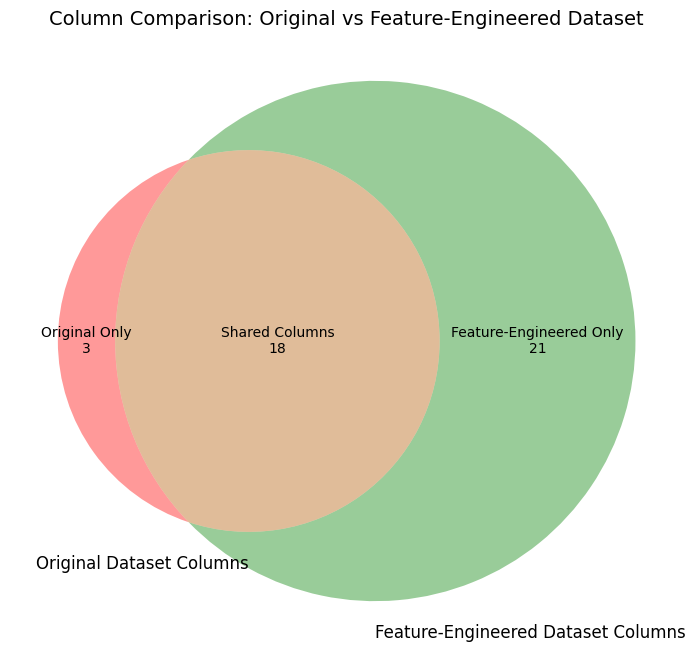

In [39]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Get the list of columns from both dataframes
original_columns = set(ampath_patient_data.columns)
feature_engineering_columns = set(ampath_patient_data_feature_engineering.columns)

# Create a Venn diagram
plt.figure(figsize=(10, 8))
venn = venn2(
    [original_columns, feature_engineering_columns],
    set_labels=('Original Dataset Columns', 'Feature-Engineered Dataset Columns')
)

# Add annotations for counts
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text(f"Original Only\n{len(original_columns - feature_engineering_columns)}")
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text(f"Feature-Engineered Only\n{len(feature_engineering_columns - original_columns)}")
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text(f"Shared Columns\n{len(original_columns & feature_engineering_columns)}")

# Add title
plt.title("Column Comparison: Original vs Feature-Engineered Dataset", fontsize=14)

# Show the plot
plt.show()


### Feature Engineering Summary

After thorough data cleaning, we performed extensive feature engineering to create predictive variables for our HIV IIT model. Key steps included:

1. **Temporal Features**:
   - Patient age at scheduled appointment
   - Time since diagnosis
   - Duration on Cotrimoxazole
   - Day of week and month of encounters

2. **Engagement Metrics**:
   - Number of past encounters
   - Percentage of early, on-time, and late arrivals

3. **Treatment Interruption Indicators**:
   - Number and percentage of past IITs (Interruptions in Treatment)
   - Previous and second-to-last appointment IIT status

4. **Risk Categorization**:
   - Age groups for demographic analysis
   - Appointment scheduling flags

We added 20 new engineered features while preserving 18 original columns, significantly enhancing the dataset's predictive potential. This comprehensive feature set captures patient history, adherence patterns, and risk factors, setting a strong foundation for building machine learning models to predict and improve HIV treatment adherence.

